In [1]:
import requests
from IPython.core.display import HTML
#styles = requests.get(
#    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
#).text
#HTML(styles)

Naive Mean Model Score: 0.5
Baseline Logistic Regression Score: 0.7336800791346246


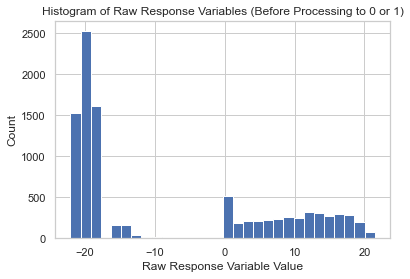

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
#import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

X_data = pd.get_dummies(X_data, drop_first=True, columns=["Race"])
X_data = X_data.rename(columns={"Race_2.0": "Other", "Race_3.0": "Black"})

plt.hist(x=y_data.values, bins=30)
plt.xlabel("Raw Response Variable Value")
plt.ylabel("Count")
plt.title("Histogram of Raw Response Variables (Before Processing to 0 or 1)")

y_data['y'] = (abs(y_data['y'])>=18)*1

# Splitting data first
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                    random_state = 109, shuffle=True, 
                                                    stratify=y_data['y'])

X_train_good = X_train.copy()
X_test_good = X_test.copy()

# Resetting variable values to aid in interpretabiltiy 
X_train_good['Sex'] = X_train['Sex']-1
X_test_good['Sex'] = X_test['Sex']-1

X_train = X_train_good
X_test = X_test_good

non_categorical = ['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells', 'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 
                   'Serum Protein', 'Systolic BP', 'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Standardizing data to aid in model convergence and performance
scaler = StandardScaler()
X_train_scaled[non_categorical] = scaler.fit_transform(X_train[non_categorical])
X_test_scaled[non_categorical] = scaler.fit_transform(X_test[non_categorical])

# Imputing X_data with KNN imputer, n_neighbors = 1 to handle NaN values
imputer = KNNImputer(n_neighbors=1)
X_train_impute = imputer.fit_transform(X_train_scaled)
X_test_impute = imputer.fit_transform(X_test_scaled)

# Turning ndarray into DF; resetting column names
X_train_impute = pd.DataFrame(X_train_impute, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_impute, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

# Baseline KNN model (n = DF size, so essentially mean) on imputed data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
y_pred = baseline_kNN_model.predict(X_test_impute)

baseline_kNN_model_accuracy = roc_auc_score(y_test, y_pred)
print("Naive Mean Model Score:", baseline_kNN_model_accuracy)

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=5000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = roc_auc_score(y_test, y_pred)
print("Baseline Logistic Regression Score:", logit_base_test_accuracy)

In [3]:
X_data.head()


,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black
0,35.0,92.0,126.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,1,0
1,71.0,78.0,210.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,1,0
2,74.0,86.0,999.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,1,0
3,64.0,92.0,385.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,0,0
4,32.0,70.0,183.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,1,0


In [4]:
y_data.head()

,y
0,0
1,0
2,0
3,1
4,0


In [5]:
print("X_data # of null values for each predictor:")
print(X_data[X_data.isnull().any(axis=1)].count())
print("\ny_data # of null values for the prediction:")
print(y_data[y_data.isnull().any(axis=1)].count())

print(X_data.columns)
print(y_data.columns)



X_data # of null values for each predictor:
Age                   1339
Diastolic BP          1281
Poverty index         1339
Red blood cells       1339
Sedimentation rate     513
Serum Albumin         1339
Serum Cholesterol     1339
Serum Iron            1339
Serum Magnesium       1339
Serum Protein         1339
Sex                   1339
Systolic BP           1282
TIBC                  1339
TS                    1339
White blood cells      298
BMI                   1339
Pulse pressure        1280
Other                 1339
Black                 1339
dtype: int64

y_data # of null values for the prediction:
y    0
dtype: int64
Index(['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells', 'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP', 'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure', 'Other', 'Black'], dtype='object')
Index(['y'], dtype='object')


In [6]:
#X_data_dropped = X_data.dropna()
#y_data_dropped = y_data.dropna()
combined = pd.concat([X_data, y_data], axis = 1)
print(combined.shape)

combined_dropped = combined.dropna()

print(combined_dropped.shape)

X_data_dropped = combined_dropped[['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure','Other','Black']]
y_data_dropped = combined_dropped[['y']]

print(X_data_dropped.shape)
print(y_data_dropped.shape)


#knn imputer.fit
#choose number of transmitter


(9932, 20)
(8593, 20)
(8593, 19)
(8593, 1)


In [7]:
# impute X_data with KNN imputer, n_neighbors = 1

imputer = KNNImputer(n_neighbors=1)
imputer_result = imputer.fit_transform(X_data)

# print(imputer_result)
# print(type(imputer_result))

# turn it into a dataframe, rename columns
X_data_imputed = pd.DataFrame(imputer_result, columns = X_data.columns)

imputed = pd.concat([X_data_imputed, y_data], axis = 1)

X_data_imputed.head()

,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black
0,35.0,92.0,126.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,1.0,0.0
1,71.0,78.0,210.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,1.0,0.0
2,74.0,86.0,999.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,1.0,0.0
3,64.0,92.0,385.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,0.0,0.0
4,32.0,70.0,183.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,1.0,0.0


In [8]:
X_data_imputed.columns

Index(['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells', 'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP', 'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure', 'Other', 'Black'], dtype='object')

In [9]:
# looking at which variables are categorical

# pd.unique(X_data_imputed["Red blood cells"])
# pd.unique(X_data_imputed["Age"])
# pd.unique(X_data_imputed["Race"])

# race and sex only?

Dropped DF Correlation Matrix:


,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black,y
Age,1.000000,0.263400,-0.025665,0.014718,0.208027,-0.199345,0.351018,-0.021265,0.087770,-0.033123,-0.155667,0.510604,-0.245259,0.076600,-0.068769,0.109757,0.505331,0.002855,-0.022344,-0.438657
Diastolic BP,0.263400,1.000000,-0.042233,0.067371,0.053945,0.013007,0.169601,-0.047725,0.019155,0.142616,-0.139052,0.701384,0.017172,-0.049950,-0.003574,0.367024,0.228974,0.164860,-0.016188,-0.168786
Poverty index,-0.025665,-0.042233,1.000000,0.027313,-0.133749,0.079018,0.028238,0.091832,0.038623,-0.083184,-0.068519,-0.078905,-0.020123,0.090705,0.009956,-0.086935,-0.076975,-0.173299,0.003405,0.101498
Red blood cells,0.014718,0.067371,0.027313,1.000000,-0.093165,0.035966,0.012462,0.058178,0.083691,0.038367,-0.156992,0.048091,-0.023849,0.062435,0.019086,0.060813,0.016571,-0.037022,-0.014580,-0.006620
Sedimentation rate,0.208027,0.053945,-0.133749,-0.093165,1.000000,-0.263014,0.124130,-0.173101,-0.104706,0.165542,0.270968,0.163140,0.014881,-0.161675,0.015778,0.135682,0.183477,0.204188,-0.002404,-0.156479
Serum Albumin,-0.199345,0.013007,0.079018,0.035966,-0.263014,1.000000,0.061070,0.110436,0.159124,0.458180,-0.113590,-0.058108,0.122741,0.044447,0.015113,-0.056252,-0.088838,-0.114003,0.008980,0.149371
Serum Cholesterol,0.351018,0.169601,0.028238,0.012462,0.124130,0.061070,1.000000,0.044567,0.073676,0.064698,0.000666,0.228813,0.028750,0.021419,0.011164,0.150966,0.188864,-0.014275,-0.010535,-0.127398
Serum Iron,-0.021265,-0.047725,0.091832,0.058178,-0.173101,0.110436,0.044567,1.000000,-0.010136,0.010141,-0.098922,-0.060438,0.019129,0.906151,-0.081658,-0.121322,-0.047753,-0.097235,0.016846,0.025153
Serum Magnesium,0.087770,0.019155,0.038623,0.083691,-0.104706,0.159124,0.073676,-0.010136,1.000000,0.036181,-0.081366,0.009813,-0.048819,0.006353,-0.003525,-0.027422,-0.000561,-0.168588,0.013388,0.029727
Serum Protein,-0.033123,0.142616,-0.083184,0.038367,0.165542,0.458180,0.064698,0.010141,0.036181,1.000000,-0.001094,0.116520,0.159642,-0.055492,0.003330,0.103029,0.055176,0.218003,0.038280,-0.060327


X_dropped Correlation Matrix:


,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black
Age,1.000000,0.263400,-0.025665,0.014718,0.208027,-0.199345,0.351018,-0.021265,0.087770,-0.033123,-0.155667,0.510604,-0.245259,0.076600,-0.068769,0.109757,0.505331,0.002855,-0.022344
Diastolic BP,0.263400,1.000000,-0.042233,0.067371,0.053945,0.013007,0.169601,-0.047725,0.019155,0.142616,-0.139052,0.701384,0.017172,-0.049950,-0.003574,0.367024,0.228974,0.164860,-0.016188
Poverty index,-0.025665,-0.042233,1.000000,0.027313,-0.133749,0.079018,0.028238,0.091832,0.038623,-0.083184,-0.068519,-0.078905,-0.020123,0.090705,0.009956,-0.086935,-0.076975,-0.173299,0.003405
Red blood cells,0.014718,0.067371,0.027313,1.000000,-0.093165,0.035966,0.012462,0.058178,0.083691,0.038367,-0.156992,0.048091,-0.023849,0.062435,0.019086,0.060813,0.016571,-0.037022,-0.014580
Sedimentation rate,0.208027,0.053945,-0.133749,-0.093165,1.000000,-0.263014,0.124130,-0.173101,-0.104706,0.165542,0.270968,0.163140,0.014881,-0.161675,0.015778,0.135682,0.183477,0.204188,-0.002404
Serum Albumin,-0.199345,0.013007,0.079018,0.035966,-0.263014,1.000000,0.061070,0.110436,0.159124,0.458180,-0.113590,-0.058108,0.122741,0.044447,0.015113,-0.056252,-0.088838,-0.114003,0.008980
Serum Cholesterol,0.351018,0.169601,0.028238,0.012462,0.124130,0.061070,1.000000,0.044567,0.073676,0.064698,0.000666,0.228813,0.028750,0.021419,0.011164,0.150966,0.188864,-0.014275,-0.010535
Serum Iron,-0.021265,-0.047725,0.091832,0.058178,-0.173101,0.110436,0.044567,1.000000,-0.010136,0.010141,-0.098922,-0.060438,0.019129,0.906151,-0.081658,-0.121322,-0.047753,-0.097235,0.016846
Serum Magnesium,0.087770,0.019155,0.038623,0.083691,-0.104706,0.159124,0.073676,-0.010136,1.000000,0.036181,-0.081366,0.009813,-0.048819,0.006353,-0.003525,-0.027422,-0.000561,-0.168588,0.013388
Serum Protein,-0.033123,0.142616,-0.083184,0.038367,0.165542,0.458180,0.064698,0.010141,0.036181,1.000000,-0.001094,0.116520,0.159642,-0.055492,0.003330,0.103029,0.055176,0.218003,0.038280


Imputed DF Correlation Matrix:


,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black,y
Age,1.000000,0.260150,-0.030336,0.030538,0.207435,-0.202611,0.346071,-0.016897,0.083664,-0.036282,-0.159728,0.507829,-0.248023,0.081067,-0.066111,0.096906,0.502980,0.009451,-0.024784,-0.443562
Diastolic BP,0.260150,1.000000,-0.060464,0.053036,0.063750,0.012697,0.168044,-0.043967,0.019320,0.145307,-0.138018,0.699397,0.019954,-0.048895,-0.000176,0.346933,0.226472,0.164655,-0.016144,-0.169466
Poverty index,-0.030336,-0.060464,1.000000,0.023129,-0.141563,0.078224,0.021656,0.088710,0.041488,-0.090320,-0.066834,-0.091296,-0.017126,0.086054,0.012390,-0.087678,-0.080639,-0.182950,0.002801,0.100513
Red blood cells,0.030538,0.053036,0.023129,1.000000,-0.034265,0.011940,-0.004661,0.040528,0.061317,-0.002208,-0.122050,0.042595,-0.033672,0.050149,0.017317,0.037731,0.019451,-0.010162,-0.025673,-0.014111
Sedimentation rate,0.207435,0.063750,-0.141563,-0.034265,1.000000,-0.249370,0.123590,-0.175114,-0.094852,0.152329,0.255341,0.169919,0.011087,-0.161848,0.009723,0.128763,0.185574,0.195518,-0.003363,-0.156635
Serum Albumin,-0.202611,0.012697,0.078224,0.011940,-0.249370,1.000000,0.059050,0.111313,0.161717,0.453112,-0.111634,-0.063672,0.120015,0.045508,0.015919,-0.054240,-0.096022,-0.110771,0.006802,0.154161
Serum Cholesterol,0.346071,0.168044,0.021656,-0.004661,0.123590,0.059050,1.000000,0.042910,0.062945,0.065038,0.002212,0.229361,0.030175,0.018212,0.013519,0.146104,0.190355,-0.011975,-0.012425,-0.126272
Serum Iron,-0.016897,-0.043967,0.088710,0.040528,-0.175114,0.111313,0.042910,1.000000,-0.005187,0.003120,-0.107358,-0.057481,0.014689,0.905566,-0.078046,-0.126294,-0.046591,-0.093943,0.016052,0.019172
Serum Magnesium,0.083664,0.019320,0.041488,0.061317,-0.094852,0.161717,0.062945,-0.005187,1.000000,0.033368,-0.081849,0.005156,-0.044119,0.008521,0.003031,-0.031072,-0.006460,-0.170695,0.010151,0.031983
Serum Protein,-0.036282,0.145307,-0.090320,-0.002208,0.152329,0.453112,0.065038,0.003120,0.033368,1.000000,0.001000,0.113875,0.154178,-0.060747,0.009155,0.108947,0.049999,0.230573,0.034210,-0.056068


X_imputed Correlation Matrix:


,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black
Age,1.000000,0.260150,-0.030336,0.030538,0.207435,-0.202611,0.346071,-0.016897,0.083664,-0.036282,-0.159728,0.507829,-0.248023,0.081067,-0.066111,0.096906,0.502980,0.009451,-0.024784
Diastolic BP,0.260150,1.000000,-0.060464,0.053036,0.063750,0.012697,0.168044,-0.043967,0.019320,0.145307,-0.138018,0.699397,0.019954,-0.048895,-0.000176,0.346933,0.226472,0.164655,-0.016144
Poverty index,-0.030336,-0.060464,1.000000,0.023129,-0.141563,0.078224,0.021656,0.088710,0.041488,-0.090320,-0.066834,-0.091296,-0.017126,0.086054,0.012390,-0.087678,-0.080639,-0.182950,0.002801
Red blood cells,0.030538,0.053036,0.023129,1.000000,-0.034265,0.011940,-0.004661,0.040528,0.061317,-0.002208,-0.122050,0.042595,-0.033672,0.050149,0.017317,0.037731,0.019451,-0.010162,-0.025673
Sedimentation rate,0.207435,0.063750,-0.141563,-0.034265,1.000000,-0.249370,0.123590,-0.175114,-0.094852,0.152329,0.255341,0.169919,0.011087,-0.161848,0.009723,0.128763,0.185574,0.195518,-0.003363
Serum Albumin,-0.202611,0.012697,0.078224,0.011940,-0.249370,1.000000,0.059050,0.111313,0.161717,0.453112,-0.111634,-0.063672,0.120015,0.045508,0.015919,-0.054240,-0.096022,-0.110771,0.006802
Serum Cholesterol,0.346071,0.168044,0.021656,-0.004661,0.123590,0.059050,1.000000,0.042910,0.062945,0.065038,0.002212,0.229361,0.030175,0.018212,0.013519,0.146104,0.190355,-0.011975,-0.012425
Serum Iron,-0.016897,-0.043967,0.088710,0.040528,-0.175114,0.111313,0.042910,1.000000,-0.005187,0.003120,-0.107358,-0.057481,0.014689,0.905566,-0.078046,-0.126294,-0.046591,-0.093943,0.016052
Serum Magnesium,0.083664,0.019320,0.041488,0.061317,-0.094852,0.161717,0.062945,-0.005187,1.000000,0.033368,-0.081849,0.005156,-0.044119,0.008521,0.003031,-0.031072,-0.006460,-0.170695,0.010151
Serum Protein,-0.036282,0.145307,-0.090320,-0.002208,0.152329,0.453112,0.065038,0.003120,0.033368,1.000000,0.001000,0.113875,0.154178,-0.060747,0.009155,0.108947,0.049999,0.230573,0.034210


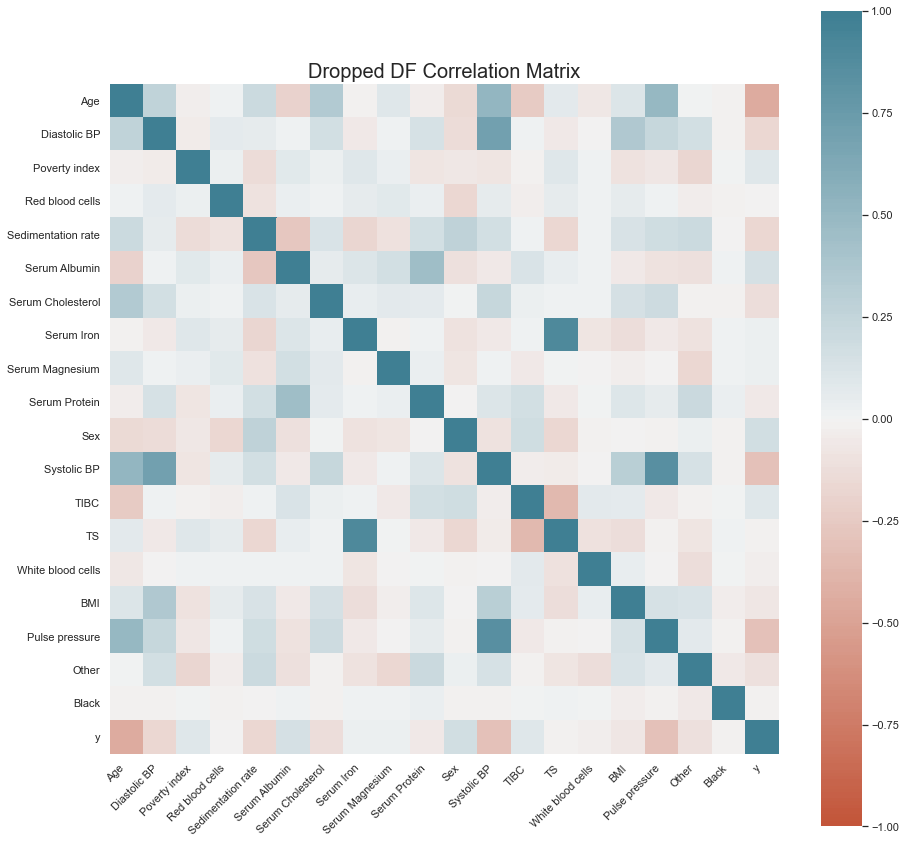

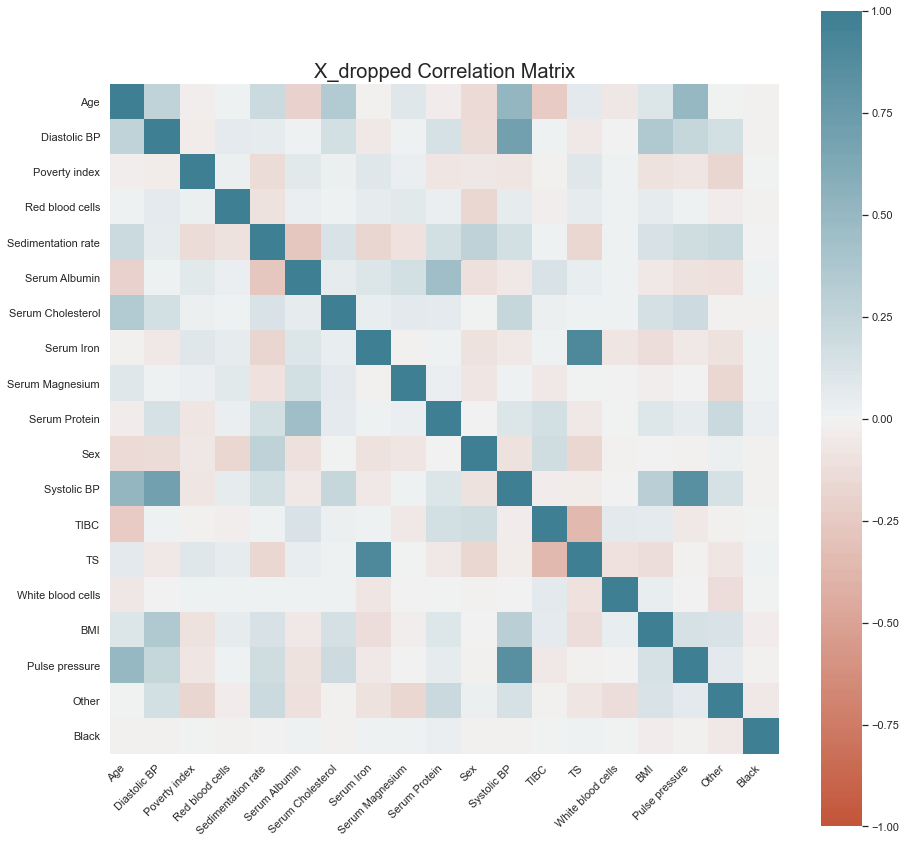

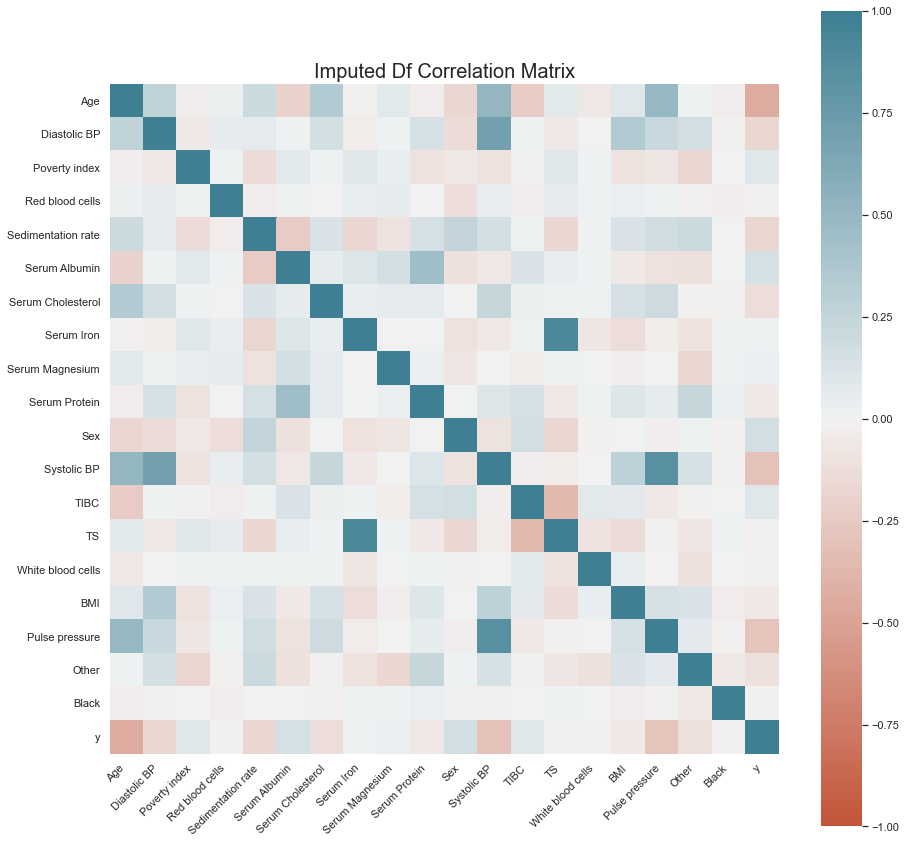

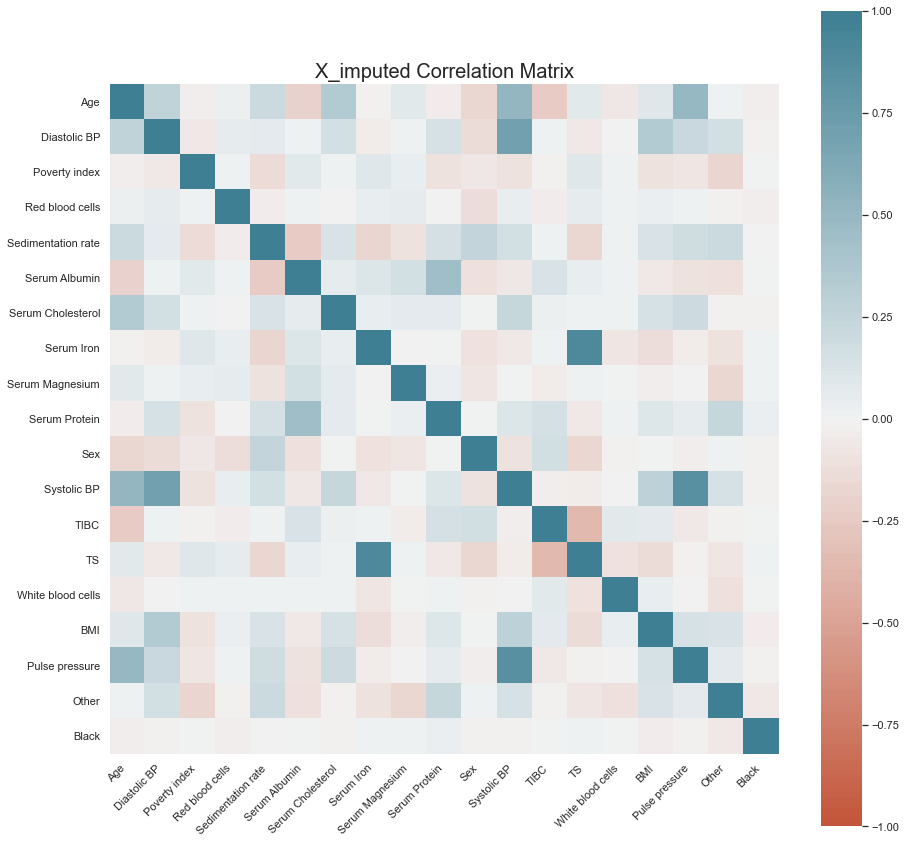

In [29]:
# Dealing with Data with Dropped NaN Values First:

print("Dropped DF Correlation Matrix:")
dropped_corr = combined_dropped.corr()
display(dropped_corr)

print("X_dropped Correlation Matrix:")
X_dropped_corr = X_data_dropped.corr()
display(X_dropped_corr)

# Then the Imputed Data Next:
print("Imputed DF Correlation Matrix:")
imputed_corr = imputed.corr()
display(imputed_corr)

print("X_imputed Correlation Matrix:")
X_imputed_corr = X_data_imputed.corr()
display(X_imputed_corr)

# Visually digestible:
ax1 = plt.figure(figsize=(15,15))
ax1 = sns.heatmap(
    dropped_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax1.set_title("Dropped DF Correlation Matrix", fontsize=20)
plt.savefig("Ray/Dropped_Corr_Matrix")

plt.show()

ax2 = plt.figure(figsize=(15,15))
ax2 = sns.heatmap(
    X_dropped_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax2.set_xticklabels(
    ax2.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax2.set_title("X_dropped Correlation Matrix", fontsize=20)
plt.savefig("Ray/X_dropped_Corr_Matrix")

plt.show()

ax3 = plt.figure(figsize=(15,15))
ax3 = sns.heatmap(
    imputed_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax3.set_xticklabels(
    ax3.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax3.set_title("Imputed Df Correlation Matrix", fontsize=20)
plt.savefig("Ray/Imputed_Corr_Matrix")

plt.show()

ax4 = plt.figure(figsize=(15,15))
ax4 = sns.heatmap(
    X_imputed_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax4.set_xticklabels(
    ax4.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax4.set_title("X_imputed Correlation Matrix", fontsize=20)
plt.savefig("Ray/X_imputed_Corr_Matrix")

plt.show()

**At first glance, it seems that response variable is moderately strongly correalted with age, systolic BP, as well as pulse pressure.**


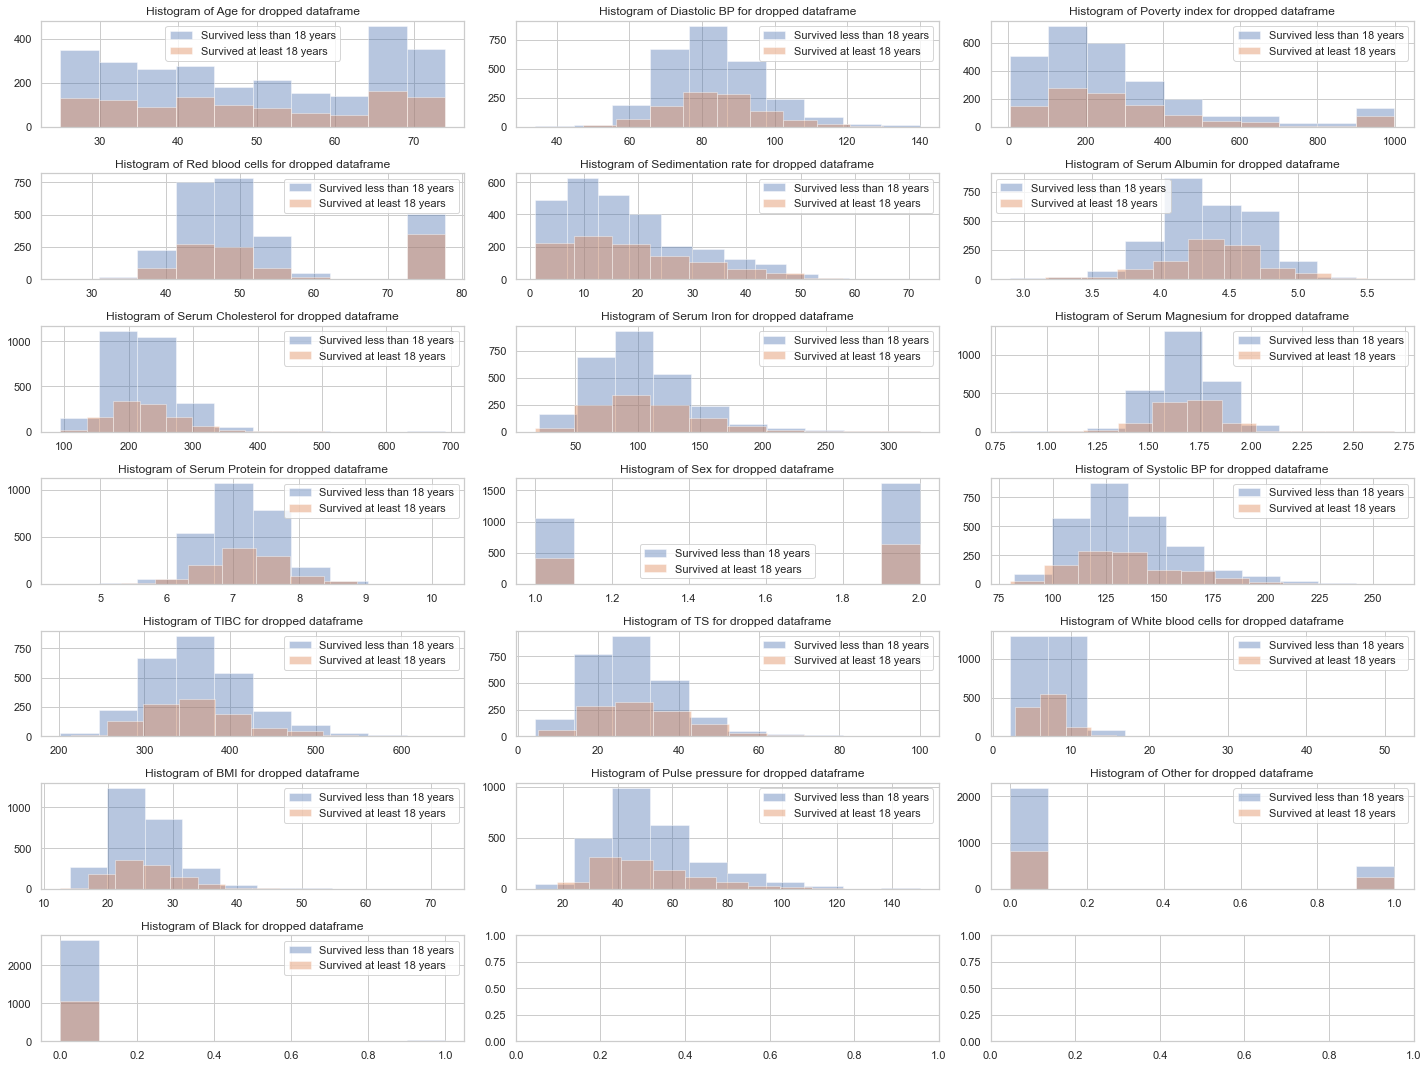

<Figure size 432x288 with 0 Axes>

In [30]:
#Histograms for dropped predictors 
indices_zero = np.where(y_train['y'].values == 0)[0]
indices_one = np.where(y_test['y'].values == 1)[0]

fig, axes = plt.subplots(7, 3, figsize = (20, 15))
for i, col in enumerate(X_data_dropped.columns):
    axes[i//3, i % 3].hist(X_data_dropped.iloc[indices_zero][col], label="Survived less than 18 years", alpha=0.4)
    axes[i//3, i % 3].hist(X_data_dropped.iloc[indices_one][col], label="Survived at least 18 years", alpha=0.4)
    axes[i//3, i % 3].set_label(col)
    axes[i//3, i % 3].set_title("Histogram of " + col+" for dropped dataframe")
    axes[i//3, i % 3].legend()
plt.tight_layout()

plt.show()
plt.clf()
plt.close()

plt.savefig("Ray/Hist_dropped")

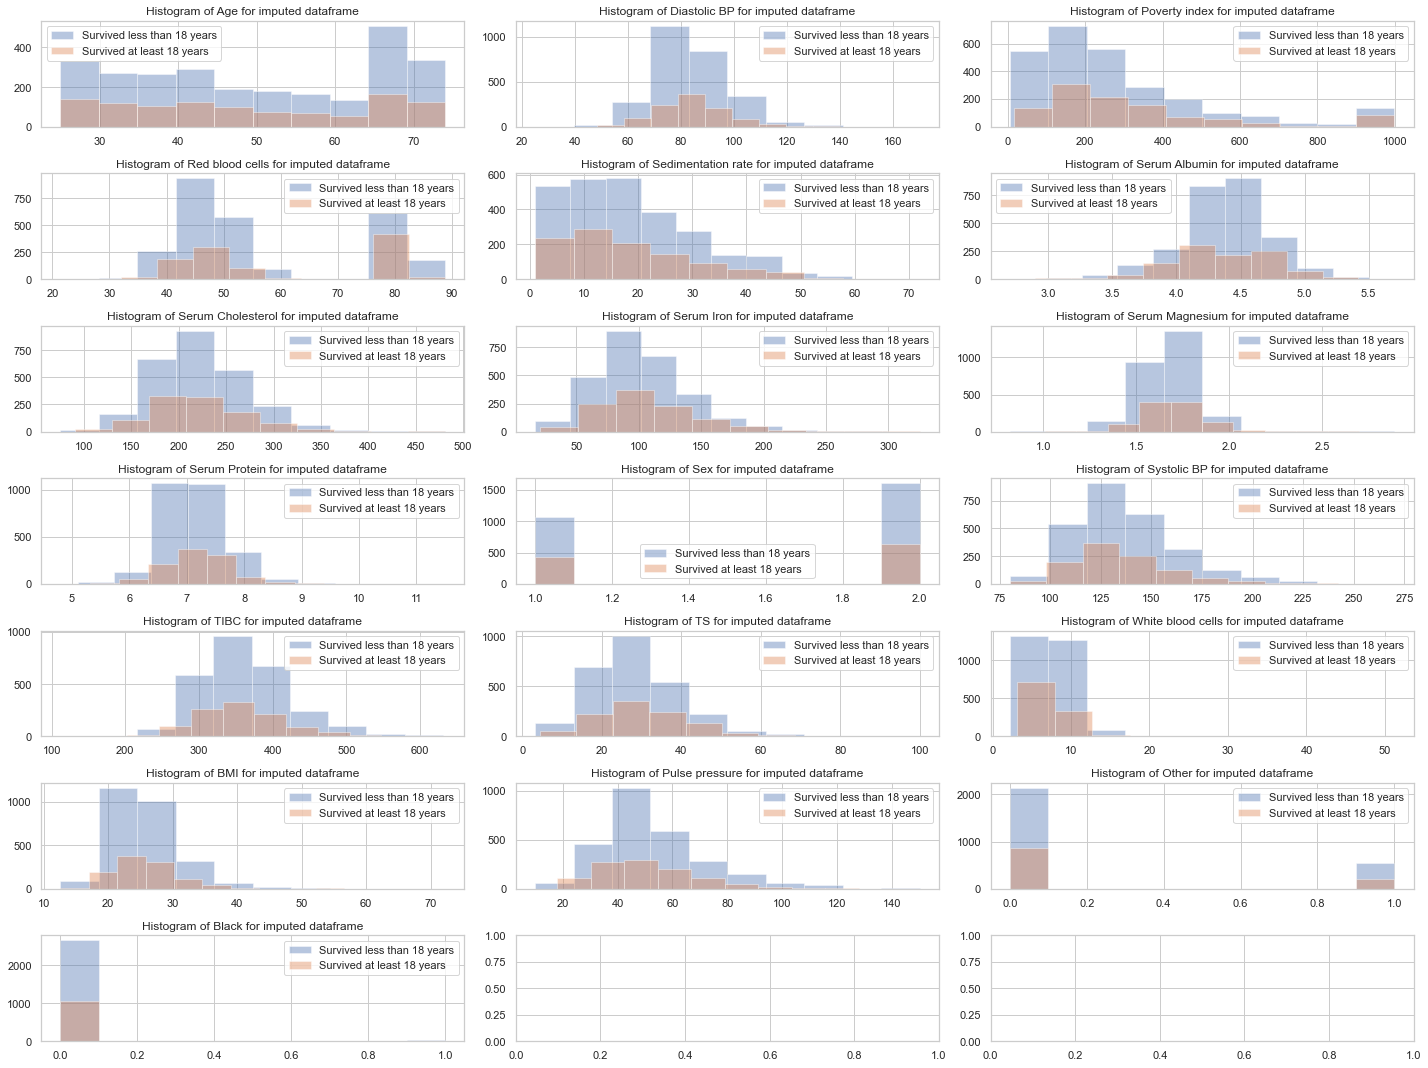

<Figure size 432x288 with 0 Axes>

In [31]:
#Histogram for imputed predictors

fig, axes = plt.subplots(7, 3, figsize = (20, 15))
for i, col in enumerate(X_data_imputed.columns):
    axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_zero][col], label="Survived less than 18 years", alpha=0.4)
    axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_one][col], label="Survived at least 18 years", alpha=0.4)
    axes[i//3, i % 3].set_label(col)
    axes[i//3, i % 3].set_title("Histogram of " + col+" for imputed dataframe")
    axes[i//3, i % 3].legend()

plt.tight_layout()

plt.show()
plt.clf()
plt.close()

plt.savefig("Ray/Hist_imputed")

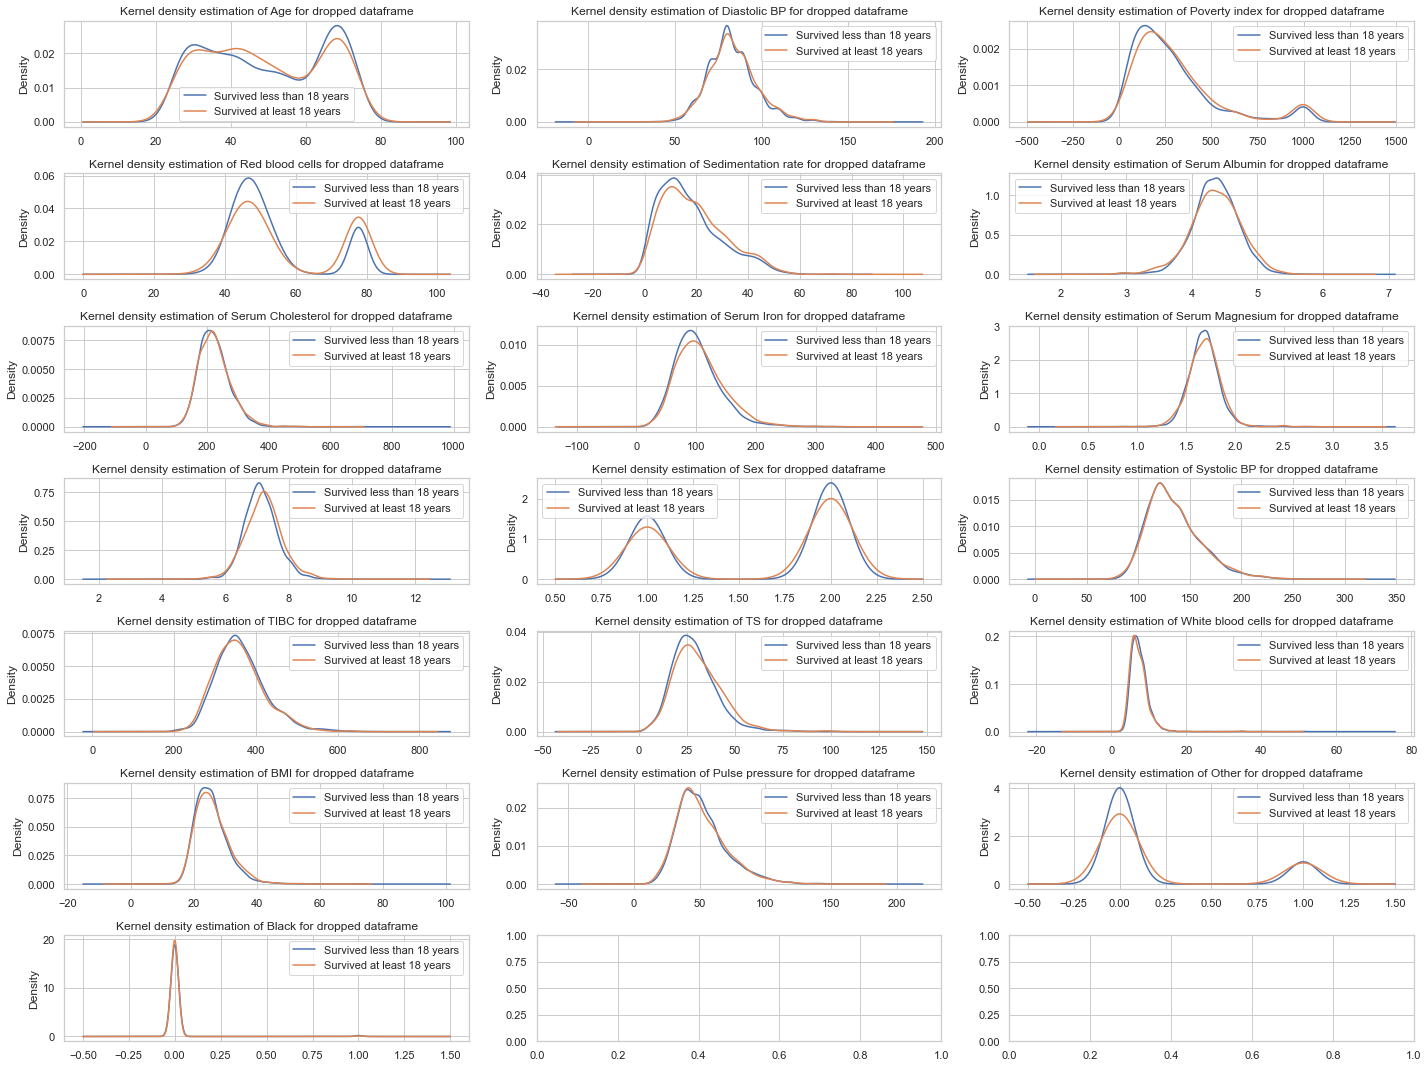

<Figure size 432x288 with 0 Axes>

In [32]:
#Kernel density estimation for dropped predictors

fig, axes = plt.subplots(7, 3, figsize = (20, 15))
for i, col in enumerate(X_data_dropped.columns):
    a = X_data_dropped.iloc[indices_zero][[col]].plot.density(ax = axes.flatten()[i])
    b = X_data_dropped.iloc[indices_one][[col]].plot.density(ax = axes.flatten()[i])

    #axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_zero][col], label="Survived less than 18 years", alpha=0.4)
    #axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_one][col], label="Survived at least 18 years", alpha=0.4)
    axes[i//3, i % 3].set_label(col)
    axes[i//3, i % 3].set_title("Kernel density estimation of " + col +" for dropped dataframe")
    axes[i//3, i % 3].legend(["Survived less than 18 years","Survived at least 18 years"]);
plt.tight_layout()


plt.show()
plt.clf()
plt.close()

plt.savefig("Ray/kde_dropped")

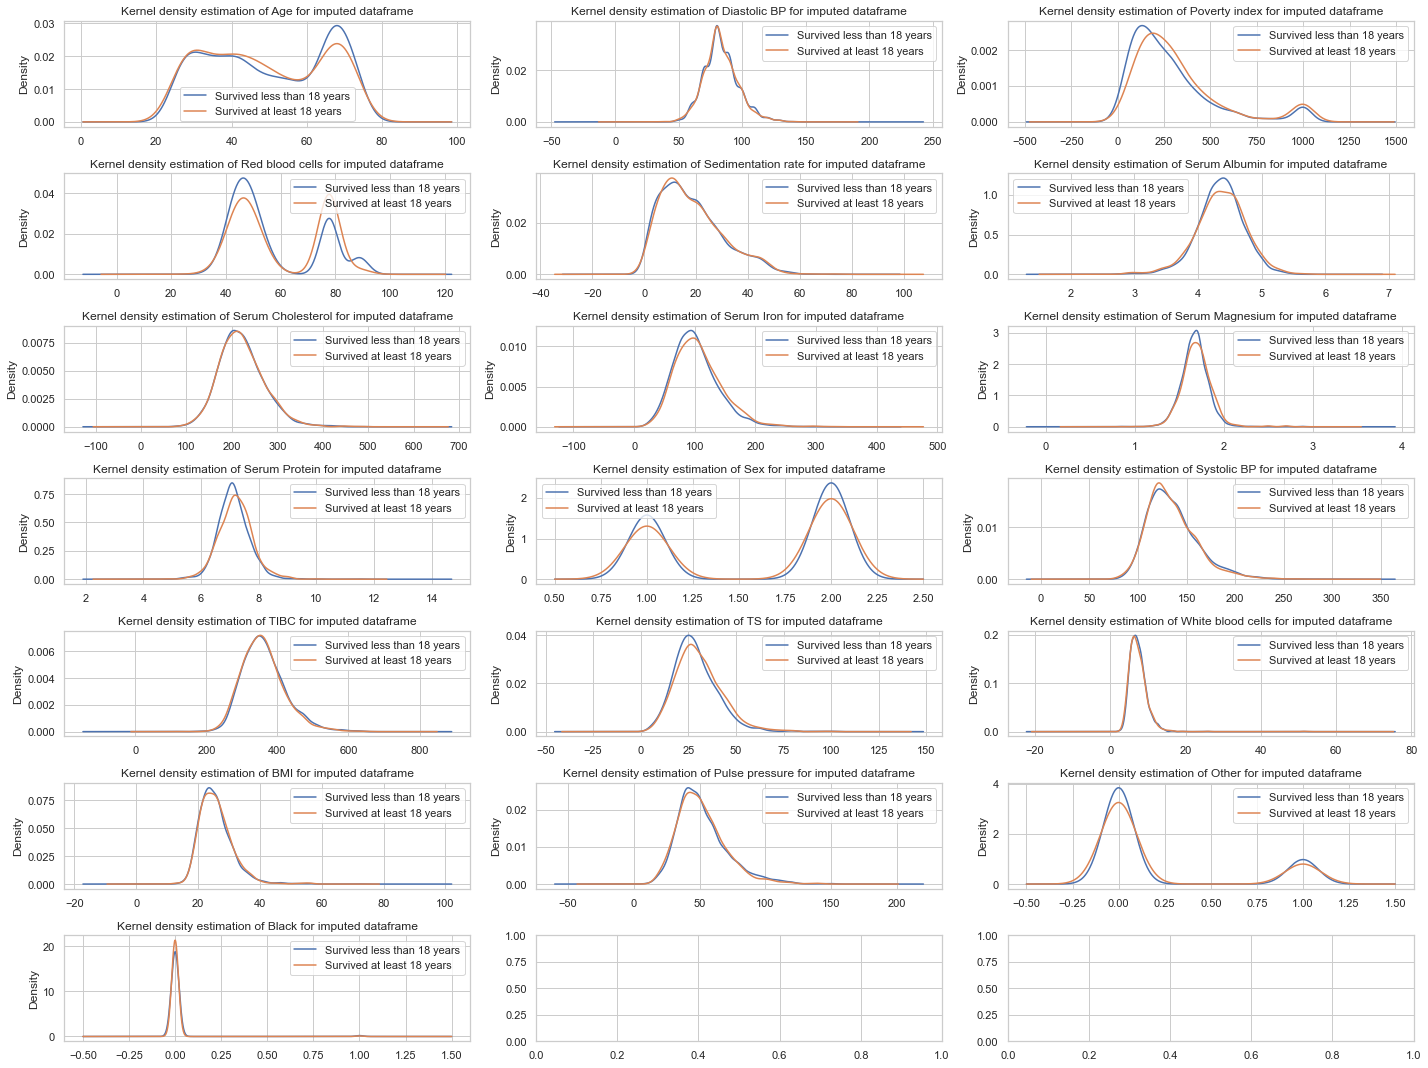

<Figure size 432x288 with 0 Axes>

In [33]:
# Kernel density estimation for imputed predictors

fig, axes = plt.subplots(7, 3, figsize = (20, 15))
for i, col in enumerate(X_data_imputed.columns):
    a = X_data_imputed.iloc[indices_zero][[col]].plot.density(ax = axes.flatten()[i])
    b = X_data_imputed.iloc[indices_one][[col]].plot.density(ax = axes.flatten()[i])

    #axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_zero][col], label="Survived less than 18 years", alpha=0.4)
    #axes[i//3, i % 3].hist(X_data_imputed.iloc[indices_one][col], label="Survived at least 18 years", alpha=0.4)
    axes[i//3, i % 3].set_label(col)
    axes[i//3, i % 3].set_title("Kernel density estimation of " + col +" for imputed dataframe")
    axes[i//3, i % 3].legend(["Survived less than 18 years","Survived at least 18 years"]);
plt.tight_layout()

plt.show()
plt.clf()
plt.close()

plt.savefig("Ray/kde_imputed")

In [15]:
imputer = KNNImputer(n_neighbors=1)
imputer_result = imputer.fit_transform(X_data)
print(type(imputer_result))
combined = pd.concat([X_data, y_data], axis = 1)
print(combined.shape)
combined_dropped = combined.dropna()

# turn it into a dataframe, rename columns
X_data_imputed = pd.DataFrame(imputer_result, columns = X_data.columns)
X_data_imputed.head()

<class 'numpy.ndarray'>
(9932, 20)


,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black
0,35.0,92.0,126.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,1.0,0.0
1,71.0,78.0,210.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,1.0,0.0
2,74.0,86.0,999.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,1.0,0.0
3,64.0,92.0,385.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,0.0,0.0
4,32.0,70.0,183.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,1.0,0.0


In [16]:
#linear regresion, knn imputation, mean imputation, then transform the dataset 

# split beforehand

# baseline with drop model
# 2nd model, with imputation ()
X_data_dropped = combined_dropped[['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure','Other','Black']]
y_data_dropped = combined_dropped[['y']]

print(X_data_dropped.shape)
print(y_data_dropped.shape)


# 

(8593, 19)
(8593, 1)


In [17]:
#Check data types of columns and recast if needed
print(X_data.dtypes)
print(y_data.dtypes)
print("All columns are floats, which means we are good to go!")

Age                   float64
Diastolic BP          float64
Poverty index         float64
Red blood cells       float64
Sedimentation rate    float64
Serum Albumin         float64
Serum Cholesterol     float64
Serum Iron            float64
Serum Magnesium       float64
Serum Protein         float64
Sex                   float64
Systolic BP           float64
TIBC                  float64
TS                    float64
White blood cells     float64
BMI                   float64
Pulse pressure        float64
Other                   uint8
Black                   uint8
dtype: object
y    int64
dtype: object
All columns are floats, which means we are good to go!


In [18]:
# See groupby statistics and see any problems
X_train, X_test, y_train, y_test = train_test_split(X_data_dropped,y_data_dropped, test_size =0.2,random_state=109)


# groupby for demographics
X_train[['Age','Poverty index','Other','Black','Sex','BMI']].describe()



,Age,Poverty index,Other,Black,Sex,BMI
count,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000
mean,49.320919,289.161914,0.166133,0.011784,1.613326,25.641083
std,15.884999,222.026227,0.372227,0.107918,0.487023,5.106703
min,25.000000,2.000000,0.000000,0.000000,1.000000,12.585333
25%,35.000000,135.000000,0.000000,0.000000,1.000000,22.108762
50%,48.000000,233.000000,0.000000,0.000000,2.000000,24.936230
75%,66.000000,373.000000,0.000000,0.000000,2.000000,28.312195
max,74.000000,999.000000,1.000000,1.000000,2.000000,58.818811


In [19]:
X_train.head()



,Age,Diastolic BP,Poverty index,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,Other,Black
5684,71.0,116.0,75.0,44.0,11.0,4.0,237.0,57.0,1.60,7.4,2.0,200.0,329.0,17.3,8.7,22.854203,84.0,1,0
5510,33.0,80.0,292.0,77.7,8.0,4.7,216.0,102.0,1.70,6.9,2.0,112.0,471.0,21.7,8.6,22.255359,32.0,0,0
7912,69.0,100.0,316.0,77.7,26.0,4.2,197.0,65.0,1.49,7.5,1.0,165.0,298.0,21.8,8.8,22.129018,65.0,0,0
7599,35.0,66.0,384.0,77.7,14.0,4.3,251.0,116.0,1.78,6.6,2.0,114.0,325.0,35.7,8.3,21.032693,48.0,0,0
213,68.0,84.0,217.0,77.7,4.0,4.4,219.0,93.0,1.87,6.4,2.0,160.0,299.0,31.1,4.5,18.772688,76.0,0,0


In [20]:
# Statistics of blood information
X_train[['Diastolic BP','Red blood cells','Sedimentation rate','Systolic BP','TIBC','Pulse pressure','TS','White blood cells']].describe()

,Diastolic BP,Red blood cells,Sedimentation rate,Systolic BP,TIBC,Pulse pressure,TS,White blood cells
count,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000
mean,83.249054,51.988667,16.013529,134.626564,363.351178,51.377509,28.496872,7.478950
std,13.303930,11.805827,11.414022,24.902325,58.728982,18.262595,11.214908,2.352901
min,38.000000,29.300000,1.000000,80.000000,196.000000,10.000000,3.200000,2.100000
25%,74.000000,44.700000,7.000000,118.000000,323.000000,40.000000,21.000000,6.000000
50%,82.000000,48.200000,14.000000,130.000000,356.000000,48.000000,27.200000,7.200000
75%,90.000000,53.200000,22.000000,150.000000,397.000000,60.000000,34.500000,8.600000
max,180.000000,88.800000,72.000000,270.000000,717.000000,150.000000,100.000000,56.000000


In [21]:
# Statistics of Serum contents
X_train[['Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein']].describe()

,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein
count,6874.000000,6874.000000,6874.000000,6874.000000,6874.000000
mean,4.370338,221.872141,101.170643,1.682633,7.108859
std,0.331533,50.111946,37.473088,0.146260,0.506600
min,2.700000,53.000000,17.000000,0.820000,4.800000
25%,4.200000,187.000000,75.000000,1.590000,6.800000
50%,4.400000,217.000000,96.000000,1.680000,7.100000
75%,4.600000,251.000000,122.000000,1.770000,7.400000
max,5.600000,793.000000,396.000000,2.700000,11.500000


In [22]:
# Groupby sex then describe demographics, blood, and serum levels:
X_train.groupby(by='Sex')[['Age','Poverty index']].describe()

Age                                                     Poverty index                                                          
      count       mean        std   min   25%   50%   75%   max         count        mean         std  min     25%    50%    75%    max
Sex                                                                                                                                    
1.0  2658.0  52.360045  15.529646  25.0  39.0  54.0  67.0  74.0        2658.0  304.525959  228.038992  2.0  148.25  250.0  385.0  999.0
2.0  4216.0  47.404886  15.809286  25.0  33.0  44.0  65.0  74.0        4216.0  279.475569  217.620715  5.0  128.00  221.0  357.0  999.0

In [23]:
X_train.groupby(by='Sex')[['Black','Other','BMI']].describe()

Black                                                Other                                                 BMI                                                                           
      count      mean       std  min  25%  50%  75%  max   count     mean       std  min  25%  50%  75%  max   count       mean      std        min        25%        50%        75%        max
Sex                                                                                                                                                                                            
1.0  2658.0  0.013544  0.115610  0.0  0.0  0.0  0.0  1.0  2658.0  0.15237  0.359447  0.0  0.0  0.0  0.0  1.0  2658.0  25.667069  4.14776  14.779363  22.894745  25.502982  27.855563  49.645994
2.0  4216.0  0.010674  0.102773  0.0  0.0  0.0  0.0  1.0  4216.0  0.17481  0.379850  0.0  0.0  0.0  0.0  1.0  4216.0  25.624701  5.62833  12.585333  21.651138  24.441123  28.621443  58.818811

In [24]:
X_train.groupby(by='Sex')[['Diastolic BP','Red blood cells','Sedimentation rate','Systolic BP','TIBC','Pulse pressure','TS','White blood cells']].describe()

Diastolic BP                                                      Red blood cells                                                     Sedimentation rate                                                    Systolic BP                                                             TIBC                                                           Pulse pressure                                                           TS                                                     White blood cells                                                
           count       mean        std   min   25%   50%   75%    max           count       mean        std   min   25%   50%   75%   max              count       mean        std  min   25%   50%   75%   max       count        mean        std   min    25%    50%    75%    max   count        mean        std    min    25%    50%    75%    max          count       mean        std   min   25%   50%   75%    max   count       mean        std  min   25%   50%   75%    max             count      mean       std  min  25%  50%    75%   max
Sex                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1.0       2658.0  85.500000  12.984495  48.0  78.0  84.0  92.0  180.0          2658.0  54.167871  10.763679  31.5  47.6  51.0  55.4  88.8             2658.0  12.096689  10.345375  1.0   4.0   9.0  17.0  65.0      2658.0  137.396539  22.955096  80.0  120.0  134.0  150.0  260.0  2658.0  349.916479  48.523194  198.0  316.0  347.0  380.0  544.0         2658.0  51.896539  17.587895  10.0  40.0  50.0  60.0  148.0  2658.0  30.677088  11.066022  6.6  22.9  29.2  36.5  100.0            2658.0  7.499059  2.211513  2.9  6.0  7.3  8.700  51.2
2.0       4216.0  81.829934  13.308664  38.0  72.0  80.0  90.0  170.0          4216.0  50.614777  12.221073  29.3  43.5  46.5  50.4  77.7             4216.0  18.482922  11.366396  1.0  10.0  16.0  25.0  72.0      4216.0  132.880218  25.906129  80.0  114.0  128.0  148.0  270.0  4216.0  371.821157  62.883475  196.0  328.0  364.0  407.0  717.0         4216.0  51.050285  18.670085  10.0  38.0  48.0  60.0  150.0  4216.0  27.122343  11.090892  3.2  19.6  25.9  33.0   97.0            4216.0  7.466271  2.438002  2.1  6.0  7.2  8.525  56.0

In [25]:
X_train.groupby(by='Sex')[['Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein']].describe()

Serum Albumin                                             Serum Cholesterol                                                          Serum Iron                                                         Serum Magnesium                                                  Serum Protein                                              
            count     mean       std  min  25%  50%  75%  max             count        mean        std   min    25%    50%    75%    max      count        mean        std   min   25%    50%    75%    max           count      mean       std   min   25%   50%   75%  max         count      mean       std  min  25%  50%  75%   max
Sex                                                                                                                                                                                                                                                                                                                                     
1.0        2658.0  4.41757  0.339801  3.0  4.2  4.4  4.6  5.5            2658.0  221.128555  47.903237  79.0  190.0  217.0  247.0  793.0     2658.0  105.709556  36.101797  25.0  80.0  101.0  125.0  396.0          2658.0  1.697325  0.145022  0.98  1.61  1.70  1.79  2.7        2658.0  7.111738  0.496322  5.0  6.8  7.1  7.4   9.9
2.0        4216.0  4.34056  0.322720  2.7  4.1  4.3  4.5  5.6            4216.0  222.340939  51.455814  53.0  186.0  217.0  254.0  591.0     4216.0   98.309061  38.039226  17.0  72.0   94.0  118.0  325.0          4216.0  1.673370  0.146296  0.82  1.58  1.67  1.76  2.5        4216.0  7.107045  0.513024  4.8  6.8  7.1  7.4  11.5

In [26]:
X_train.groupby(by='Black')[['Age','Poverty index']].describe()

Age                                                     Poverty index                                                          
        count       mean        std   min   25%   50%   75%   max         count        mean         std   min    25%    50%    75%    max
Black                                                                                                                                    
0      6793.0  49.368762  15.897100  25.0  35.0  48.0  66.0  74.0        6793.0  288.975121  222.138463   2.0  134.0  233.0  373.0  999.0
1        81.0  45.308642  14.364576  25.0  35.0  41.0  57.0  73.0          81.0  304.827160  213.138558  13.0  168.0  257.0  373.0  999.0

In [27]:
X_train.groupby(by='Black')[['Sex','BMI']].describe()

Sex                                                  BMI                                                                            
        count      mean       std  min  25%  50%  75%  max   count       mean       std        min        25%        50%        75%        max
Black                                                                                                                                         
0      6793.0  1.614014  0.486863  1.0  1.0  2.0  2.0  2.0  6793.0  25.661102  5.115796  12.585333  22.118411  24.966677  28.339156  58.818811
1        81.0  1.555556  0.500000  1.0  1.0  2.0  2.0  2.0    81.0  23.962190  3.952742  15.549184  21.494238  23.230662  26.405415  36.220412

In [28]:
X_train.groupby(by='Sex')[['Diastolic BP','Red blood cells','Sedimentation rate','Systolic BP','TIBC','Pulse pressure','TS','White blood cells']].describe()

Diastolic BP                                                      Red blood cells                                                     Sedimentation rate                                                    Systolic BP                                                             TIBC                                                           Pulse pressure                                                           TS                                                     White blood cells                                                
           count       mean        std   min   25%   50%   75%    max           count       mean        std   min   25%   50%   75%   max              count       mean        std  min   25%   50%   75%   max       count        mean        std   min    25%    50%    75%    max   count        mean        std    min    25%    50%    75%    max          count       mean        std   min   25%   50%   75%    max   count       mean        std  min   25%   50%   75%    max             count      mean       std  min  25%  50%    75%   max
Sex                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1.0       2658.0  85.500000  12.984495  48.0  78.0  84.0  92.0  180.0          2658.0  54.167871  10.763679  31.5  47.6  51.0  55.4  88.8             2658.0  12.096689  10.345375  1.0   4.0   9.0  17.0  65.0      2658.0  137.396539  22.955096  80.0  120.0  134.0  150.0  260.0  2658.0  349.916479  48.523194  198.0  316.0  347.0  380.0  544.0         2658.0  51.896539  17.587895  10.0  40.0  50.0  60.0  148.0  2658.0  30.677088  11.066022  6.6  22.9  29.2  36.5  100.0            2658.0  7.499059  2.211513  2.9  6.0  7.3  8.700  51.2
2.0       4216.0  81.829934  13.308664  38.0  72.0  80.0  90.0  170.0          4216.0  50.614777  12.221073  29.3  43.5  46.5  50.4  77.7             4216.0  18.482922  11.366396  1.0  10.0  16.0  25.0  72.0      4216.0  132.880218  25.906129  80.0  114.0  128.0  148.0  270.0  4216.0  371.821157  62.883475  196.0  328.0  364.0  407.0  717.0         4216.0  51.050285  18.670085  10.0  38.0  48.0  60.0  150.0  4216.0  27.122343  11.090892  3.2  19.6  25.9  33.0   97.0            4216.0  7.466271  2.438002  2.1  6.0  7.2  8.525  56.0